### Image Segmentation with Watershed Algorithm 유역 알고리즘을 이용한 이미지 분할

Learn to segment images with watershed segmentation

#### 목표
In this chapter,

* We will learn to use marker-based image segmentation using watershed algorithm
* We will see: [cv.watershed()](https://docs.opencv.org/3.4/d7/d1b/group__imgproc__misc.html#ga3267243e4d3f95165d55a618c65ac6e1)

#### 이론
모든 그레이 스케일 이미지는 높은 강도가 봉우리와 언덕을 나타내고 지저귐 강도는 계곡을 나타내는 지형 표면으로 볼 수 있습니다. 당신은 모든 고립 된 골짜기 (지역 미니 마)를 다른 색깔의 물 (라벨)로 채우기 시작합니다. 물이 올라감에 따라 주변의 봉우리 (그라디언트)에 따라 다른 계곡의 물이 분명히 다른 색상으로 병합되기 시작합니다. 이를 방지하기 위해 물이 합쳐지는 곳에서 장벽을 만듭니다. 모든 봉우리가 물에 잠길 때까지 물을 채우고 장벽을 세우는 작업을 계속하십시오. 그런 다음 생성 한 장벽을 사용하여 세그먼트 화 결과를 얻을 수 있습니다. 이것은 유역 뒤에있는 "철학"입니다. [유역](http://cmm.ensmp.fr/~beucher/wtshed.html)의 CMM 웹 페이지를 방문하여 일부 애니메이션의 도움을 받아이를 이해할 수 있습니다.

그러나이 방법은 노이즈 또는 이미지의 다른 불규칙으로 인해 과분 된 결과를 제공합니다. 따라서 OpenCV는 마커 기반 유역 알고리즘을 구현했습니다.이 알고리즘에서는 모든 계곡 지점을 병합하고 그렇지 않은 지점을 지정합니다. 대화 형 이미지 세분화입니다. 우리가하는 일은 우리가 알고있는 대상에 대해 다른 레이블을주는 것입니다. 우리는 하나의 색 (또는 강도)으로 전경 또는 대상이 될 것이라고 확신하는 영역에 레이블을 붙이고, 다른 색으로 배경 또는 비 목적이라고 확신하는 영역에 레이블을 붙이고, 마지막으로 우리가 아무것도 모르는 영역을 레이블링합니다. 그것은 0으로 레이블을 붙이십시오. 그것은 우리의 마커입니다. 그런 다음 유역 알고리즘을 적용합니다. 그러면 우리 마커는 우리가 준 레이블로 업데이트되고 객체의 경계는 -1의 값을 갖게됩니다

#### Code
아래에서는 유역과 함께 거리 변환을 사용하여 서로 닿는 물체를 구분하는 방법에 대한 예를 살펴 보겠습니다.

아래의 동전 이미지를 고려해 볼 때, 동전은 서로 닿아 있습니다. 비록 당신이 그것을 문턱을 치더라도, 그것은 서로 만질 것입니다.
![](water_coins.jpg)
우리는 동전의 대략적인 견적을 찾는 것으로 시작합니다. 이를 위해 오츠의 이진화를 사용할 수 있습니다.

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import bonghanUtil as util

img = cv.imread('water_coins.jpg')
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

util.saveImage('result_coins_using_otus.jpg', thresh)

![](result_coins_using_otus.jpg)
이제 이미지에서 작은 흰색 노이즈를 제거해야합니다. 이를 위해 형태학적인 개방을 사용할 수 있습니다. 객체의 작은 구멍을 제거하기 위해 형태 학적 닫기를 사용할 수 있습니다. 이제 우리는 물체의 중심에 가까운 영역이 전경이고 물체에서 훨씬 먼 영역이 배경임을 확실히 알고 있습니다. 우리가 확신 할 수없는 지역은 동전의 경계 영역입니다.

그래서 우리는 그들이 동전이라고 확신하는 영역을 추출해야합니다. 침식은 경계 픽셀을 제거합니다. 남은 것이 무엇이든, 우리는 그것이 동전임을 확신 할 수 있습니다. 물체가 서로 닿지 않으면 작동합니다. 그러나 서로 만져보고 있기 때문에 거리 변환을 찾아 적절한 임계 값을 적용하는 것이 좋습니다. 다음으로 우리는 동전이 아니라고 확신하는 지역을 찾아야합니다. 이를 위해 우리는 결과를 넓힌다. Dilation은 오브젝트 경계를 배경으로 증가시킵니다. 이 방법으로 경계 영역이 제거 되었기 때문에 결과에서 백그라운드의 영역이 실제로 배경인지 확인할 수 있습니다. 아래 이미지를 참조하십시오.
![](water_fgbg.jpg)
나머지 지역은 동전인지 배경인지에 관계없이 우리가 전혀 모르는 지역입니다. 유역 알고리즘이이를 발견해야합니다. 이 영역은 일반적으로 전경과 배경이 만나는 (또는 두 개의 다른 동전이 만나는) 동전의 경계선 주위에 있습니다. 우리는 그것을 국경이라고 부릅니다. sure_bg 영역에서 sure_fg 영역을 뺀 값으로 구할 수 있습니다.

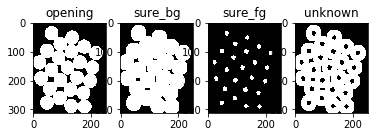

In [2]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations = 2)
util.showImage(opening, 'opening')

# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=3)
util.showImage(sure_bg, 'background')

# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
util.showImage(dist_transform)
ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
util.showImage(sure_fg, 'foreground')

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)
util.showImage(unknown, 'unknown')

plt.subplot(141), plt.title('opening'), plt.imshow(opening, cmap = 'gray')
plt.subplot(142), plt.title('sure_bg'), plt.imshow(sure_bg, cmap = 'gray')
plt.subplot(143), plt.title('sure_fg'), plt.imshow(sure_fg, cmap = 'gray')
plt.subplot(144), plt.title('unknown'), plt.imshow(unknown, cmap = 'gray')
plt.show()

![](water_dt.jpg)
이제 우리는 배경과 모든 동전의 영역이 무엇인지 확실히 알고 있습니다. 그래서 마커 (원래 이미지와 같은 크기이지만 int32 데이터 유형을 가진 배열)를 만들고 그 안의 영역에 레이블을 지정합니다. 우리가 알고있는 영역 (전경 또는 배경인지 여부)은 양의 정수로 표시되지만 정수는 다르며 확실히 모르는 영역은 0으로 남습니다. 이를 위해 우리는 cv.connectedComponents ()를 사용 합니다. 이미지의 배경에 0으로 레이블을 지정하면 다른 객체는 1부터 시작하는 정수로 레이블됩니다.

그러나 배경이 0으로 표시되면 유역은 알려지지 않은 영역으로 간주합니다. 그래서 우리는 그것을 다른 정수로 표시하려고합니다. 대신 unknown으로 정의 된 알 수없는 영역을 0으로 표시합니다.

In [3]:
# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

JET 색상 맵에 표시된 결과를 확인하십시오. 진한 파란색 영역에는 알 수없는 영역이 표시됩니다. 동전은 다른 값으로 채색되어 있습니다. 배경이 확실한 잔여 영역은 알 수없는 영역에 비해 밝은 파란색으로 표시됩니다.
![](water_marker.jpg)

이제 마커가 준비되었습니다. 마지막 단계, 유역 적용시기입니다. 그런 다음 마커 이미지가 수정됩니다. 경계 영역에는 -1이 표시됩니다.

In [4]:
markers = cv.watershed(img,markers)
img[markers == -1] = [255,0,0]

아래 결과를보십시오. 일부 동전의 경우 접촉하는 지역이 적절하게 분할되고 일부는 분할되지 않습니다.
![](water_result.jpg)

#### Additional Resources
[유역 변환 에 대한 CMM 페이지](http://cmm.ensmp.fr/~beucher/wtshed.html)

#### Exercises
OpenCV 샘플에는 watershed 세그먼트 화에 대한 대화식 샘플 인 watershed.py가 있습니다. 그것을 실행하고, 그것을 즐기고, 그것을 배우십시오.

In [1]:
%run watershed.py


Watershed segmentation

This program demonstrates the watershed segmentation algorithm
in OpenCV: watershed().

Usage
-----
watershed.py [image filename]

Keys
----
  1-7   - switch marker color
  SPACE - update segmentation
  r     - reset
  a     - toggle autoupdate
  ESC   - exit


marker:  1
marker:  2
marker:  3
marker:  4
